In [175]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
import joblib
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
random_state = 42

In [176]:
df = pd.read_csv('data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [177]:
df['sex'] = df['sex'].apply({'male' :0, 'female' :1}.get)
df['smoker'] = df['smoker'].apply({'yes' :1, 'no' :0}.get)
df['region'] = df['region'].apply({'southwest' :1, 'southeast' :2, 'northwest' :3 , 'northeast' :4}.get)

In [178]:
X = df.drop('charges', axis = 1)
y = df['charges']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, random_state = random_state)

In [179]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

#czy skalować ? 

In [180]:
XGB_model = xgb.XGBRegressor(max_depth = 3, n_estimators=50, learning_rate =.2,objective='reg:squarederror')
XGB_model.fit(X_train, y_train);

In [181]:
def show_metrics(model,x_test,y_test):
    y_pred = model.predict(x_test)
    MAE_XGB= metrics.mean_absolute_error(y_test, y_pred)
    MSE_XGB = metrics.mean_squared_error(y_test, y_pred)
    RMSE_XGB =np.sqrt(MSE_XGB)
    R2_XGB_perc = (metrics.r2_score(y_test, y_pred))*100
    print("RMSE: {:.4f}, R2: {:.2f}%, MSE: {:.4f}".format(RMSE_XGB,R2_XGB_perc,MSE_XGB))

In [182]:
show_metrics(XGB_model,X_test,y_test)

RMSE: 4542.0406, R2: 85.92%, MSE: 20630132.7660


In [183]:
scores = cross_val_score(XGB_model, X_train, y_train, cv=5)
print(np.sqrt(scores))

[0.94819722 0.93530789 0.89704753 0.90296387 0.90987528]


In [184]:
feats = df.columns.to_list()

In [185]:
import scikitplot as skplt
def plot_feature_importances(model, feat_list):

    model_name = type(model).__name__
    skplt.estimators.plot_feature_importances(model, feature_names=df[feat_list].columns,
                                            title=f'{model_name} feature importances')
    plt.xticks(rotation=90)

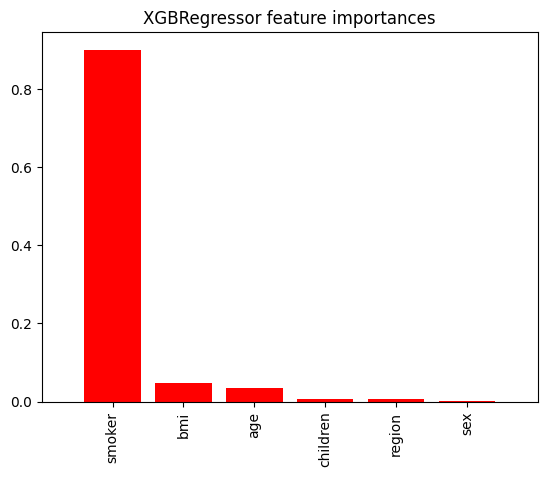

In [186]:
plot_feature_importances(XGB_model,feats)

In [187]:
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

In [188]:

def run_xgb_hyperopt(X, y, cv, max_evals, random_state):
    
    # funkcja, której wynik chcemy minimalizować (RMSE)
    def objective(space):
        XGB_model = xgb.XGBRegressor(
            max_depth = int(space['max_depth']),
            n_estimators = int(space['n_estimators']),
            min_child_weight = space['min_child_weight'],
            subsample = space['subsample'],
            learning_rate = space['learning_rate'],
            gamma = space['gamma'],
            colsample_bytree = space['colsample_bytree'],
            objective='reg:squarederror',
            random_state=random_state,
            early_stopping_rounds = 10,
            eval_metric = 'rmse' )
        
        for train_idx, test_idx in cv.split(X):

            eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
            XGB_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, verbose=False)
            y_pred = XGB_model.predict(X[test_idx])

            rmse = np.sqrt(metrics.mean_squared_error(y[test_idx], y_pred))
            
            print("RMSE: {:.4f}".format(rmse))
            return{'loss': rmse, 'status': STATUS_OK }
    
    # parametry do optymizacji    
    space ={
            'max_depth': hp.choice('max_depth', np.arange(2, 4, 1, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
            'subsample': hp.uniform('subsample', 0.7, 1),
            'n_estimators' : hp.choice('n_estimators', np.arange(20, 300, 2, dtype=int)),
            'learning_rate' : hp.quniform('learning_rate', 0.025, 0.8, 0.025),
            'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
        }

    trials = Trials() # przechowuje info dla kazdego kroku.
    
    best = fmin(fn=objective , #fmin - funkcja, ktora chcemy minimalizowac
                space=space, #przestrzeń potencjalnych (hyper)parametrów
                algo=tpe.suggest, #algorytm wyszukujacy najlepsze parametry
                max_evals=max_evals, #ilość prób
                trials=trials ) #zapisywane wynikow w trakcie
    
    hyperparams = space_eval(space, best)

    print("The best params: ", hyperparams)
    return hyperparams

In [189]:
X_train_v = X_train.values
y_train_v = y_train.values

In [190]:
best_XGB = run_xgb_hyperopt(X_train_v,y_train_v,cv=kf,max_evals=100, random_state = random_state)

RMSE: 4250.9216                                        
RMSE: 4817.9410                                        
RMSE: 4279.9844                                                                 
RMSE: 4319.3268                                                                 
RMSE: 4308.8873                                                                 
RMSE: 4446.7769                                                                 
RMSE: 4919.3205                                                                 
RMSE: 4185.6286                                                                 
RMSE: 4493.2980                                                                 
RMSE: 4933.7659                                                                 
RMSE: 4297.9716                                                                 
RMSE: 5017.3353                                                                  
RMSE: 4443.3247                                                              

In [191]:
XGB_model = xgb.XGBRegressor(**best_XGB, objective='reg:squarederror', random_state=random_state)

In [192]:
XGB_model.fit(X_train, y_train)
y_pred_XGB = XGB_model.predict(X_test)

In [193]:
np.sqrt(metrics.mean_squared_error(y_test,y_pred_XGB))

4831.323037752149

In [ ]:
show_metrics(XGB_model,X_test,y_test)

RMSE: 4834.1379, R2: 84.05%, MSE: 23368889.5517


In [ ]:
joblib.dump(XGB_model,'joblib_model_xgb')

['joblib_model_xgb']

In [ ]:
model = joblib.load('joblib_model_xgb')

In [ ]:
data = {'age' : 40,
        'sex' : 1,
        'bmi' : 40.30,
        'children' : 4,
        'smoker' : 1,
        'region' : 2}
data = pd.DataFrame(data,index=[0])

In [ ]:
data 

,age,sex,bmi,children,smoker,region
0,40,1,40.3,4,1,2


In [ ]:
model.predict(data)

array([43491.918], dtype=float32)